In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, log_loss, accuracy_score
from sklearn import preprocessing
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import BorderlineSMOTE

!pip install fitter > /dev/null
from fitter import Fitter, get_common_distributions
import warnings

warnings.filterwarnings("ignore")
parent_folder='/content/drive/MyDrive/Seznam/Aukce'

# Část 1 - aukce

In [ ]:
df_raw = pd.read_csv(parent_folder+'/bids_train.csv')
df = df_raw.set_index('auction_id').fillna(0) # Nezucastnil se => nabidl 0
df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%d %H:%M:%S')
#df.info()
df.head()

,time,A,B,C
auction_id,,,,
100,2022-01-01 02:10:56,70.0,48.0,105.0
101,2022-01-01 02:12:14,7.0,127.0,6.0
102,2022-01-01 02:13:33,20.0,22.0,9.0
103,2022-01-01 02:14:51,18.0,12.0,27.0
104,2022-01-01 02:16:10,13.0,5.0,66.0


### 1. Spočítejte procenta výher pro každého účastníka. Tj. počet aukcí, které vyhrál účastník A děleno celkový počet aukcí atd.


In [ ]:
winRate = df[['A','B','C']].idxmax(axis=1).value_counts()/len(df)
winRate

C    0.438
A    0.319
B    0.243
dtype: float64

### 2. Pro každou aukci určete cenu, kterou musel výherce zaplatit.

In [ ]:
def win_amount(df):
  winAmount = df[['A','B','C']].apply(lambda x: x.nlargest(2).iloc[1], axis=1)
  winAmount.name = "win_amounts"
  return winAmount

winAmount = win_amount(df)
winAmount

auction_id
100     70.0
101      7.0
102     20.0
103     18.0
104     13.0
        ... 
1095    26.0
1096     9.0
1097    13.0
1098     8.0
1099    21.0
Name: win_amounts, Length: 1000, dtype: float64

### 3. Jaký je celkový výnos prodejce ze všech aukcí?

In [ ]:
winAmount.sum()

15297.0

### 4. Řekněme, že z pohledu prodejce jsou ceny náhodné veličiny. Zkuste odhadnout, jakým rozdělením pravděpodobnosti se ceny řídí.

Distribuce je z běžných rozdělení nejpodobnější Logaritmicko-normálnímu rozdělení.

,sumsquare_error,aic,bic,kl_div
lognorm,0.000314,1711.365781,-47838.760147,inf
chi2,0.001102,2185.796407,-44094.971329,inf
expon,0.001524,2039.941744,-43136.159700,inf
cauchy,0.002021,1670.639488,-42296.075550,inf
exponpow,0.002722,2701.035638,-41400.661464,inf


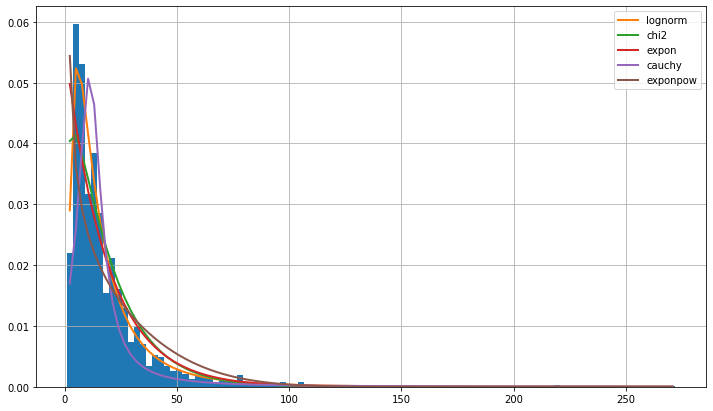

In [ ]:
plt.figure(figsize=(12,7))
values = pd.concat([df_raw[df_raw['A'].notna()]['A'],\
                    df_raw[df_raw['B'].notna()]['B'],\
                    df_raw[df_raw['C'].notna()]['C']]).values #uzivam puvodni data
f = Fitter(values, distributions=get_common_distributions())
f.fit()
f.summary()

### 5. Který účastník má nejvyšší ochotu platit?

Ten s nejvyšší nabídkou. Snížením nabídky blíže druhému se jeho pozice nezlepší ani nezhorší a při snížení pod úroveň druhého by rovnou prohrál a svojí pozici si zhorší.

### 6. Zobrazte vývoj ceny v čase (tj. ceny, kterou musel výherce zaplatit v každé aukci).

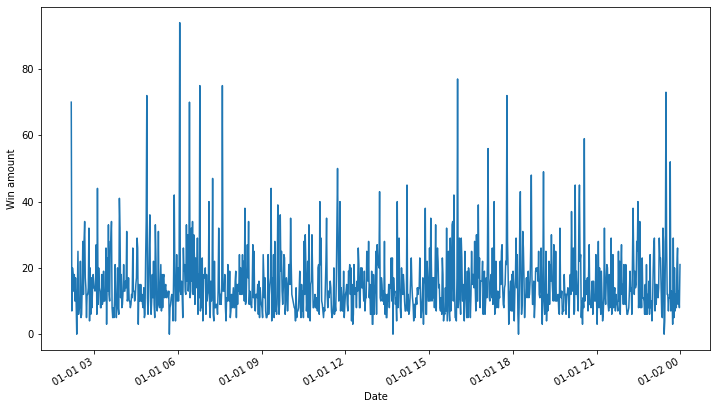

In [ ]:
df[['time']].join(winAmount).set_index('time')['win_amounts'].plot(xlabel = 'Date', ylabel = 'Win amount', figsize=(12,7))

# Část 2 - online aukce

In [ ]:
df_raw2 = pd.read_csv(parent_folder+'/features_train.csv')
df2 = df_raw2.set_index(['bidder_id','auction_id'])
df2['time'] = pd.to_datetime(df2['time'], format='%Y-%m-%d %H:%M:%S')
df2.describe()

,feature_1,feature_2,prob,click
count,2979.000000,2979.000000,2979.000000,2979.000000
mean,1.499835,2.179218,0.311277,0.110104
std,0.418896,0.066651,0.100115,0.313072
min,0.676600,1.987653,0.130358,0.000000
25%,1.065189,2.135058,0.240877,0.000000
50%,1.497357,2.197904,0.290492,0.000000
75%,1.924078,2.235024,0.384801,0.000000
max,2.352646,2.271352,0.541882,1.000000


### 1. Zkuste za pomocí datové analýzy odhalit a interpretovat co zachycují faktory 1 a 2.


První faktor je vázaný ke konkrétní nabídce, druhý ke konkrétní aukci. Střední hodnota prvního faktoru se významně liší pro různé účastníky, ale není pravda, že by se s rostoucí/klesající hodnotou zvyšovala/snižovala odhadovaná pravděpodobnost. Druhý faktor silně koreluje s odhadovanou pravděpodobností prokliků. Ten by mohl být interpretován jako ohodnocení šance prokliku pro danou aukci.


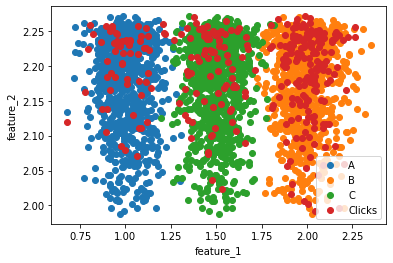

In [ ]:
# Graf zavislosti prokliku na faktorech a ucastnicich
def graph(df, xaxis='feature_1', yaxis='feature_2'):
  for bidder in ['A','B','C']:
    plt.scatter(df[df['bidder_id'] == bidder][df['click']==0][xaxis],\
                df[df['bidder_id'] == bidder][df['click']==0][yaxis])
  plt.scatter(df[df['click']!=0][xaxis],\
              df[df['click']!=0][yaxis])
  plt.legend(['A','B','C', 'Clicks'])
  plt.xlabel(xaxis)
  plt.ylabel(yaxis)

graph(df2.reset_index())

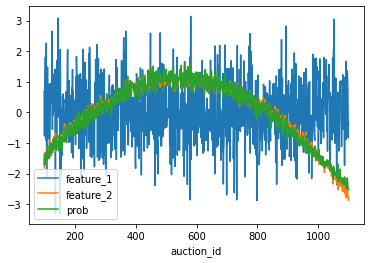

In [ ]:
# V grafu je videt zavislost feature_2 na prob
bidder = 'A'
feat = df2.loc[bidder][['feature_1', 'feature_2', 'prob']]
std_feat = (feat-feat.mean())/feat.std() # Normalizace hodnot
std_feat.plot()

### 2. Spojte tato data s daty o nabízených cenách. Pro každou aukci a každého účastníka spočítejte online bid = nabízená cena (“bid”) * odhadnutá pravděpodobnost prokliku (“prob”).


In [ ]:
f2 = df2.join(pd.Series(df2.index.map(lambda x: df.loc[x[1]][x[0]]), index=df2.index, name='bid'))
f2['bid_online'] = f2['bid']*f2['prob']
f2.head()

,,time,feature_1,feature_2,prob,click,bid,bid_online
bidder_id,auction_id,,,,,,,
A,100,2022-01-01 02:10:56,1.069595,2.058711,0.174908,0.0,70.0,12.243548
B,100,2022-01-01 02:10:56,1.988148,2.058711,0.316245,0.0,48.0,15.179772
C,100,2022-01-01 02:10:56,1.591261,2.058711,0.167141,0.0,105.0,17.549771
A,101,2022-01-01 02:12:14,0.926382,2.090531,0.189602,0.0,7.0,1.327213
B,101,2022-01-01 02:12:14,1.990614,2.090531,0.344666,0.0,127.0,43.772601


### 3. Určete výherce každé aukce, tentokrát podle online bidu. Spočítejte, v kolika procentech případů vyhrál každý nabízející. Jak se tyto poměry změnily oproti předchozímu případu, kdy jsme uvažovali jen nabízenou cenu? Čím může být rozdíl způsoben?


Online bid zvýhodnil účastníka B, nejspíše z důvodu, že jeho predikované pravděpodobnosti prokliku jsou většinou skoro dvojnásobné než u konkurentů.

In [ ]:
max_bid_online_mask = f2.groupby('auction_id')['bid_online'].transform(max) == f2['bid_online']
print('Dataset pouze vitezu:')
display(f2[max_bid_online_mask].head())
print('Procenta vyher jednotlivych ucastniku:')
display(f2[max_bid_online_mask].reset_index()['bidder_id'].value_counts()/len(df))

Dataset pouze vitezu:


time  feature_1  feature_2      prob  \
bidder_id auction_id                                                       
C         100        2022-01-01 02:10:56   1.591261   2.058711  0.167141   
B         101        2022-01-01 02:12:14   1.990614   2.090531  0.344666   
          102        2022-01-01 02:13:33   2.007467   2.083768  0.340472   
C         103        2022-01-01 02:14:51   1.551829   2.076118  0.176485   
          104        2022-01-01 02:16:10   1.501737   2.076457  0.175955   

                      click    bid  bid_online  
bidder_id auction_id                            
C         100           0.0  105.0   17.549771  
B         101           0.0  127.0   43.772601  
          102           0.0   22.0    7.490375  
C         103           0.0   27.0    4.765103  
          104           0.0   66.0   11.613004

Procenta vyher jednotlivych ucastniku:


B    0.423
C    0.337
A    0.240
Name: bidder_id, dtype: float64

### 4. V online aukcích se cena, kterou má zaplatit výherce aukce, počítá podle následujícího pravidla:
p.p. = odhadnutá pravděpodobnost prokliku

konečná cena za proklik = p.p. druhého v pořadí děleno p.p. prvního v pořadí krát nabízená cena druhého

Tuto cenu platí výherce pouze tehdy, pokud získal i klik. Můžete si všimnout, že
finální cena nezávisí na nabízené ceně daného inzerenta.

In [ ]:
# Vitezove aukci a castka kterou plati pokud dostanou klik
def find_winners(f2, df, max_bid_online_mask):
  winners = f2[max_bid_online_mask].copy(deep=True) #Vitezove aukce 
  second = f2[~max_bid_online_mask]
  second_bid_online_mask = second.groupby('auction_id')['bid_online'].transform(max) == second['bid_online']
  second = second[second_bid_online_mask].droplevel(0) #Druzi v aukci
  second_bid = df.join(second['bid_online']).fillna(0)['bid_online'] # Když nikdo druhý nedá nabídku, tak předpokládám 0
  winners['bid_actual'] = second_bid / winners['prob'] #(bid*2nd_prob)/1st_prob
  return winners

winners = find_winners(f2, df, max_bid_online_mask)
winners.head()

time  feature_1  feature_2      prob  \
bidder_id auction_id                                                       
C         100        2022-01-01 02:10:56   1.591261   2.058711  0.167141   
B         101        2022-01-01 02:12:14   1.990614   2.090531  0.344666   
          102        2022-01-01 02:13:33   2.007467   2.083768  0.340472   
C         103        2022-01-01 02:14:51   1.551829   2.076118  0.176485   
          104        2022-01-01 02:16:10   1.501737   2.076457  0.175955   

                      click    bid  bid_online  bid_actual  
bidder_id auction_id                                        
C         100           0.0  105.0   17.549771   90.820339  
B         101           0.0  127.0   43.772601    3.850721  
          102           0.0   22.0    7.490375   11.154779  
C         103           0.0   27.0    4.765103   22.621135  
          104           0.0   66.0   11.613004   13.943227

### 5. Spočítejte celkový výnos z aukce.


In [ ]:
winners[winners['click']!=0]['bid_actual'].sum()

4756.691573120195

# Část 3 - model

In [ ]:
def normalize(data, columns = None, validation = None):
  dt = data.copy()
  standard_scaler = preprocessing.StandardScaler()
  if columns == None:
    columns = dt.select_dtypes(include=['float64']).columns 
  standard_scaler.fit(dt[columns])
  dt[columns] = standard_scaler.transform(dt[columns])
  
  if validation is not None:
    dv = validation.copy()
    dv[columns] = standard_scaler.transform(dv[columns])
    return dt, dv
  return dt

def undersampling(X,y):
  return TomekLinks().fit_resample(X, y)

def oversampling(X,y):
  return BorderlineSMOTE(random_state=random_state).fit_resample(X, y)

### 1. Formulujte a odhadněte vlastní model, který bude predikovat pravděpodobnost, zda návštěvník internetové stránky klikne na reklamu (target variable je sloupeček “click”). Reportujte údaje o modelu. Jakou lze očekávat chybu modelu?


Pro model jsem zvolil logistickou regresi, mimo jiné pro možnost z ni extrahovat vypočtené pravděpodobnosti klasifikace. Pro predikci používám sloupce "feature_2" a "bidder_id", protože pořád pracuju se stejnými účastníky aukce. Jednotlivé účastníky jsem reprezentoval v one-hot kódování. Nimi jsem nahradil sloupec "feature_1", který nepřidával při predikci významnou hodnotu. Sloupec "prob" jsem samozřejmě nepoužil, protože danou hodnotu se snažím predikovat. 

Ve výchozím stavu vracel model pro všechny vstupy velmi malé a velmi podobné pravděpodobnosti (\<0.3). Proto jsem se rozhodl minoritní třídě pomoci samplingem. Zvolil jsem Borderline SMOTE pro upsampling, a poté Tomek Links na undersampling. 

Tím jsem získal vyrovnanější dataset. Na stejné hranici pravděpodobnostní hodnoty se většinou zhoršila přesnost (accuracy) predikce a počet falešně pozitivních klasifikací, ale zvýšila se Log Loss a počet skutečně pozitivních klasifikací, kterých je nyní přibližně stejně jako falešných negativních klasifikací. Stejné porovnání je i s pravděpodobnostmi sloupce "prob" původního datasetu. 

Z ROC křivek ale vidím, že upsampling jen přeškáloval hodnoty pravděpodobností na rozmanitější hodnoty. Křivka modelu zůstala víceméně stejná.

Zvolené hodnoty chyby modelu (matice záměn, log loss, accuracy, ROC) jsou naměřené níže, pro predikované pravděpodobnosti a pro sloupec "prob" původního datasetu.


In [ ]:
# Priprava trenovaciho datasetu
random_state=42
def preprocess_dataset(df, train=True):
  if train:
    y = df[['click', 'prob']].copy(deep=True)
    X = df.drop(columns={'click', 'prob', 'time',	'auction_id'}).copy(deep=True)
  else:
    y = df[['click']].copy(deep=True)
    X = df.drop(columns={'click', 'time',	'auction_id'}).copy(deep=True)
  y.click = y['click'] > 0
  X = X.join(pd.get_dummies(X['bidder_id']))
  X = X.drop(columns={'bidder_id','feature_1'})
  return X, y

X, y = preprocess_dataset(df_raw2)

In [ ]:
# Deleni trenovaciho datasetu na validacni a sampling
def sampling(X,y):
  X, y = oversampling(X,y)
  X, y = undersampling(X,y)
  return X, y

X_train, X_test, y_train, y_test = train_test_split(normalize(X), y, test_size=.3, random_state=random_state)
y_train = y_train['click']
X_train, y_train = sampling(X_train,y_train)

In [ ]:
# Predikce modelem
clf = LogisticRegression(random_state=random_state).fit(X_train, y_train)
y_pred = pd.DataFrame(clf.predict_proba(X_test), index=y_test.index)[1]

Odhadnute parametry logistickou regresi:
 [-0.63649318] [[ 0.47605095 -1.09077882  1.17269844 -0.08119018]]
Matice zamen:
 [[598 203]
 [ 51  42]]
Log loss:
 0.5523590656003462
Accuracy:
 0.7158836689038032
Graf zavislosti predikovane pravdepodobnosti prokliku na feature_2:



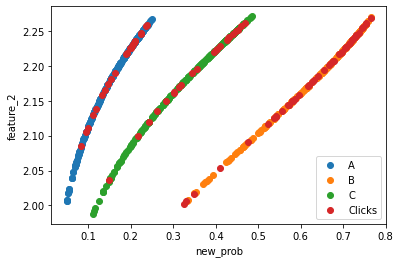

In [ ]:
# Hodnoty metrik pro vystup modelu
print('Odhadnute parametry logistickou regresi:\n', clf.intercept_, clf.coef_)
print('Matice zamen:\n', confusion_matrix(y_test['click'], y_pred > 0.5))
print('Log loss:\n', log_loss(y_test['click'], y_pred))
print('Accuracy:\n', accuracy_score(y_test['click'], y_pred > 0.5))
print('Graf zavislosti predikovane pravdepodobnosti prokliku na feature_2:\n')
graph(df_raw2.join(y_pred.rename('new_prob'), how='right'),'new_prob')


In [ ]:
# Hodnoty metrik pro sloupec "prob" puvodniho datasetu
print('Metriky pro sloupec "prob" z puvodniho datasetu:')
print('Matice zamen:\n', confusion_matrix(y_test['click'], y_test['prob'] > 0.5))
print('Log loss:\n', log_loss(y_test['click'], y_test['prob']))
print('Accuracy:\n', accuracy_score(y_test['click'], y_test['prob'] > 0.5))

Metriky pro sloupec "prob" z puvodniho datasetu:
Matice zamen:
 [[773  28]
 [ 86   7]]
Log loss:
 0.44650969423811987
Accuracy:
 0.87248322147651


My model probability:


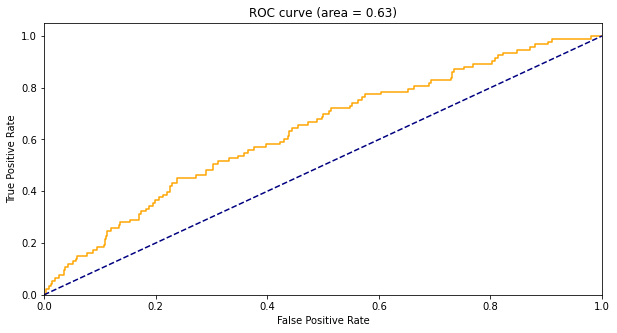

'prob' column probability:


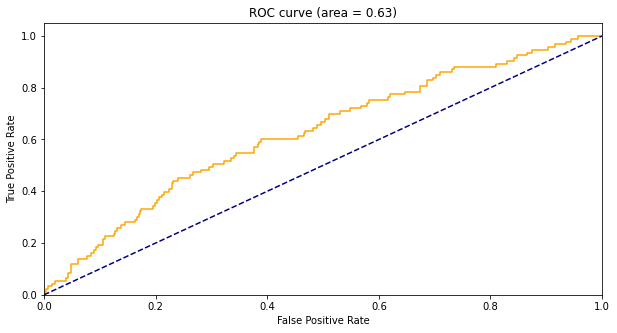

In [ ]:
# Z ROC krivek je videt ze upsampling ale model vicemene jen preskaloval 
# a krivky jsou podobne
from sklearn.metrics import roc_curve, auc
def roc(real, pred):
  fpr, tpr, _ = roc_curve(real, pred)
  roc_auc = auc(fpr, tpr)
  plt.figure(figsize=(10,5))
  plt.plot(fpr, tpr, color="orange")
  plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("ROC curve (area = %0.2f)" % roc_auc)
  plt.show()
  return fpr, tpr
  
print('My model probability:')
roc(y_test['click'], y_test['prob'])
print("'prob' column probability:")
fpr, tpr = roc(y_test['click'], y_pred)

### 2. Načtěte soubory “bids_test.csv” a “features_test.csv”, které obsahují podobná data, nicméně tentokrát bez odhadnutých pravděpodobností prokliku.


In [ ]:
# Nacteni dat, vsechny features jsou 10 nasobne proti train datech, predpokladam
# ze je chyba v datech a opravim
df_test_raw = pd.read_csv(parent_folder+'/bids_test.csv')
df_test_raw2 = pd.read_csv(parent_folder+'/features_test.csv')
df_test_modified2 = df_test_raw2.copy(deep=True)
df_test_modified2['feature_1'] /= 10
df_test_modified2['feature_2'] /= 10
df_test_modified2.describe()[:3]

,auction_id,feature_1,feature_2,click
count,299.00000,299.000000,299.000000,299.00000
mean,49.61204,1.509378,2.042625,0.09699
std,28.89747,0.415712,0.026171,0.29644


#### 2.1. Použijte model odhadnutý v bodu 1 k predikci pravděpodobnosti prokliku.

In [ ]:
#Predikce pravdepodobnosti prokliku a jeji ulozeni do sloupce prob
def predict_prob(df, clf, X_train):
  X, _ = preprocess_dataset(df,train=False)
  _, X = normalize(X_train, validation = X) # normalizuji podle skaly trenovacich dat
  return pd.DataFrame(clf.predict_proba(X), index=X.index)[1].rename("prob")

pred = predict_prob(df_test_modified2, clf, X)
df_test2_pred = df_test_modified2.join(pred)
display(df_test2_pred.head())

,auction_id,bidder_id,time,feature_1,feature_2,click,prob
0,0,A,2022-01-01 00:00:00,0.924157,1.996885,0.0,0.046098
1,0,B,2022-01-01 00:00:00,1.829279,1.996885,0.0,0.317277
2,0,C,2022-01-01 00:00:00,1.614743,1.996885,0.0,0.117098
3,1,A,2022-01-01 00:01:18,0.997719,1.983486,0.0,0.042067
4,1,B,2022-01-01 00:01:18,2.016334,1.983486,0.0,0.296915


#### 2.2. Jaký je očekávaný celkový výnos z těchto aukcí?

In [ ]:
df_test = df_test_raw.set_index('auction_id').fillna(0)
df_test2 = df_test2_pred.set_index(['bidder_id','auction_id'])
f3 = df_test2.join(pd.Series(df_test2.index.map(lambda x: df_test.loc[x[1]][x[0]]), index=df_test2.index, name='bid'))
f3['bid_online'] = f3['bid']*f3['prob']
max_bid_online_mask_test = f3.groupby('auction_id')['bid_online'].transform(max) == f3['bid_online']
winners = find_winners(f3, df_test, max_bid_online_mask_test)

winners[winners['click']!=0]['bid_actual'].sum()

282.79855090993055